In [2]:
import os

# Configurar directorio de trabajo
target_dir = os.getcwd() if 'cnn-cards' in os.getcwd().lower() else './CNN-Cards'

if os.path.isdir(target_dir):
    os.chdir(target_dir)
print(f'Directorio actual: {os.getcwd()}')

DATA_PATH = './Datasets/Cards/'

Directorio actual: /tf/CNN-Cards


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import regularizers
from vit_keras import vit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Global variables
SIZE = 224
CLASSES = 53
EPOCHS = 100
PATIENCE_ES = 25
BATCH_SIZE = 64

path_models = 'Models'
path_results = 'Results'

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU disponible: {tf.config.list_physical_devices("GPU")}')

TensorFlow version: 2.15.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-11-30 23:25:33.616838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-30 23:25:33.711471: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-30 23:25:33.711512: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Cargar datos con Data Augmentation agresiva

In [4]:
# Data augmentation agresiva para ViT
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.15,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=(0.9, 1.1)
)

valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

train_dataset = train_generator.flow_from_directory(
    train_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataset = valid_generator.flow_from_directory(
    valid_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = test_generator.flow_from_directory(
    test_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## Cargar modelo base y reconstruir con regularizacion

In [12]:
# Cargar modelo pre-entrenado para obtener accuracy de referencia
from vit_keras import vit, layers as vit_layers

# Obtener TODOS los custom objects del modulo vit_keras dinamicamente
custom_objects = {}
for name_obj in dir(vit_layers):
    obj = getattr(vit_layers, name_obj)
    if isinstance(obj, type):
        custom_objects[name_obj] = obj

for name_obj in dir(vit):
    obj = getattr(vit, name_obj)
    if isinstance(obj, type):
        custom_objects[name_obj] = obj

print(f"Custom objects registrados: {list(custom_objects.keys())}")

# Intentar cargar el modelo existente
try:
    vit_pretrained = tf.keras.models.load_model(
        'Models/ViT_B16_2.h5', 
        custom_objects=custom_objects,
        compile=False
    )
    print(f'Modelo ViT_B16 cargado correctamente.')
    vit_pretrained.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    _, acc_original = vit_pretrained.evaluate(test_dataset, verbose=0)
    print(f'Accuracy original: {acc_original:.4f}')
except Exception as e:
    print(f'Error cargando modelo: {e}')
    print('Usando valor de referencia conocido...')
    acc_original = 0.91
    vit_pretrained = None

Custom objects registrados: ['AddPositionEmbs', 'ClassToken', 'MultiHeadSelfAttention', 'TransformerBlock', 'ConfigDict']
Modelo ViT_B16 cargado correctamente.
Modelo ViT_B16 cargado correctamente.
Accuracy original: 0.9245
Accuracy original: 0.9245


In [6]:
# Construir modelo mejorado partiendo de ViT_B16_2 (si se cargo)
if 'vit_pretrained' in locals() and vit_pretrained is not None:
    print("Usando modelo ViT_B16_2 como base (partiendo de accuracy ~0.91)...")
    
    # Descongelar mas capas para fine-tuning adicional
    for layer in vit_pretrained.layers[:-10]:
        layer.trainable = False
    for layer in vit_pretrained.layers[-10:]:
        layer.trainable = True
    
    vit_improved = vit_pretrained
    print("Modelo base cargado con pesos existentes.")
    
else:
    print("Construyendo modelo desde ImageNet (pesos de ViT_B16_2 no disponibles)...")
    
    # Base ViT desde ImageNet
    base_vit = vit.vit_b16(image_size=SIZE, include_top=False, pretrained_top=False, pretrained=True)

    # Descongelar ultimas 5 capas del transformer
    for layer in base_vit.layers[:-5]:
        layer.trainable = False
    for layer in base_vit.layers[-5:]:
        layer.trainable = True

    # Arquitectura mejorada con regularizacion
    inputs = tf.keras.layers.Input(shape=(SIZE, SIZE, 3))
    x = base_vit(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(CLASSES, activation='softmax')(x)

    vit_improved = tf.keras.Model(inputs=inputs, outputs=outputs)

vit_improved.summary()
print(f'\nCapas entrenables: {sum([1 for l in vit_improved.layers if l.trainable])}')

Construyendo modelo desde ImageNet (pesos de ViT_B16_2 no disponibles)...


/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0     

In [6]:
# Contar parametros entrenables
trainable_params = np.sum([np.prod(v.shape) for v in vit_improved.trainable_variables])
non_trainable_params = np.sum([np.prod(v.shape) for v in vit_improved.non_trainable_variables])
print(f'Parametros entrenables: {trainable_params:,}')
print(f'Parametros no entrenables: {non_trainable_params:,}')

Parametros entrenables: 21,506,613
Parametros no entrenables: 64,533,504


## Configurar callbacks y entrenar

In [7]:
name = 'ViT_B16_3'

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=PATIENCE_ES,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{name}',
    histogram_freq=1
)

callbacks_list = [checkpoint, early_stop, reduce_lr, tensorboard]

In [8]:
# Compilar con learning rate bajo
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

vit_improved.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [9]:
# Entrenar
history = vit_improved.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/100


I0000 00:00:1764529811.995956     179 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  9/120 [=>............................] - ETA: 1:44 - loss: 4.3222 - accuracy: 0.0192 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 

## Visualizar resultados

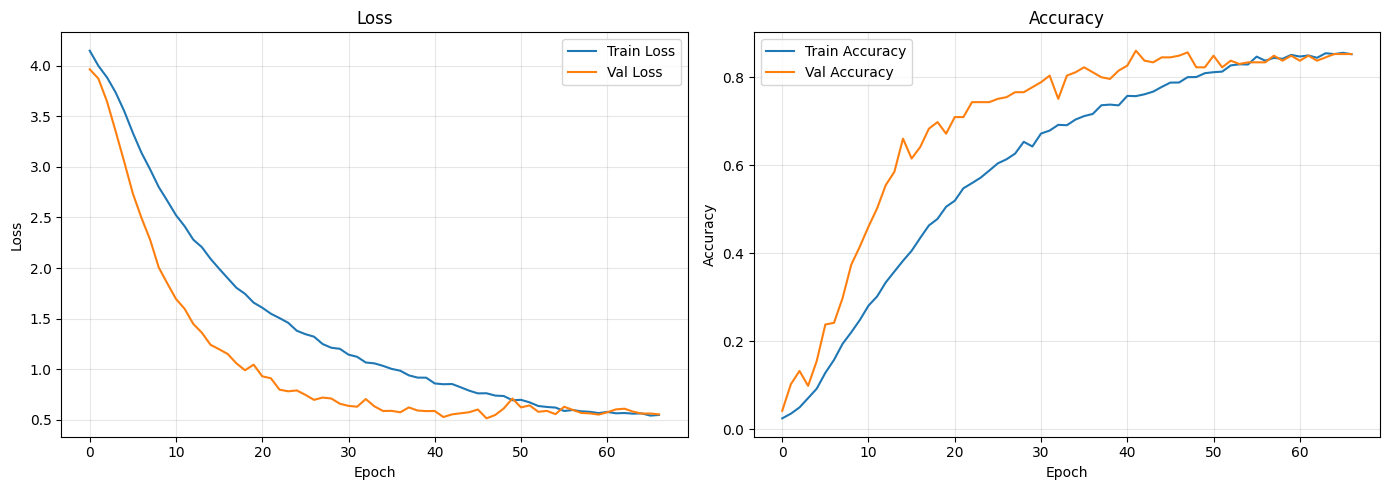

In [ ]:
def plot_and_save(h, dir, name):
    history_df = pd.DataFrame(h.history)
    history_df['epoch'] = list(range(len(history_df)))
    history_df.to_csv(os.path.join(dir, name + '.csv'), header=True, index=False)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history_df['epoch'], history_df['loss'], label='Train Loss')
    axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history_df['epoch'], history_df['accuracy'], label='Train Accuracy')
    axes[1].plot(history_df['epoch'], history_df['val_accuracy'], label='Val Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dir, name + '_curves.png'), dpi=150)
    plt.show()

plot_and_save(history, path_results, name)

## Evaluacion en Test Set

In [ ]:
# Cargar mejor modelo (necesita custom_objects para capas de vit_keras)
from vit_keras import layers as vit_layers

custom_objects = {
    'ClassToken': vit_layers.ClassToken,
    'AddPositionEmbs': vit_layers.AddPositionEmbs,
}

best_model = tf.keras.models.load_model(
    os.path.join(path_models, name + '.h5'),
    custom_objects=custom_objects
)

# Evaluar
_, acc_improved, _, _ = best_model.evaluate(test_dataset)

print(f'\n=== Comparacion de resultados ===')
print(f'Accuracy original (ViT_B16_2): {acc_original:.4f}')
print(f'Accuracy mejorado (ViT_B16_3): {acc_improved:.4f}')
print(f'Mejora: {(acc_improved - acc_original)*100:.2f}%')

5/5 [==============================] - 4s 317ms/step - loss: 0.5826 - accuracy: 0.8679 - precision_1: 0.9184 - recall_1: 0.8491

=== Comparacion de resultados ===
Accuracy original (ViT_B16_2): 0.9100
Accuracy mejorado (ViT_B16_3): 0.8679
Mejora: -4.21%
5/5 [==============================] - 4s 317ms/step - loss: 0.5826 - accuracy: 0.8679 - precision_1: 0.9184 - recall_1: 0.8491

=== Comparacion de resultados ===
Accuracy original (ViT_B16_2): 0.9100
Accuracy mejorado (ViT_B16_3): 0.8679
Mejora: -4.21%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def show_report(model, dataframe):
    labels = dataframe.class_indices
    true_labels = dataframe.labels
    pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)
    keys_array = np.array(list(labels.keys()))
    true_text = [keys_array[value] for value in true_labels]
    pred_text = [keys_array[value] for value in pred_labels]
    print(classification_report(true_text, pred_text))

def show_matrix(model, dataframe):
    labels = dataframe.class_indices
    true_labels = dataframe.labels
    pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)
    keys_array = np.array(list(labels.keys()))
    true_text = [keys_array[value] for value in true_labels]
    pred_text = [keys_array[value] for value in pred_labels]
    cf = confusion_matrix(true_text, pred_text, labels=keys_array)
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(cf, annot=False, square=True, cbar=True,
                cmap=plt.cm.Blues, xticklabels=keys_array, yticklabels=keys_array, ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(f'Confusion Matrix - {name}')
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

show_report(best_model, test_dataset)

                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       1.00      1.00      1.00         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       0.83      1.00      0.91         5
eight of diamonds       0.71      1.00      0.83         5
  eight of hearts       0.71      1.00      0.83         5
  eight of spades       0.67      0.80      0.73         5
    five of clubs       1.00      0.40      0.57         5
 five of diamonds       0.43      0.60      0.50         5
   five of hearts       1.00      0.80      0.89         5
   five of spades       0.80      0.80      0.80         5
    four of clubs       1.00      0.80      0.89         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.00      1.00      1.00         5
   four of spades       1.00      0.80      0.89       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


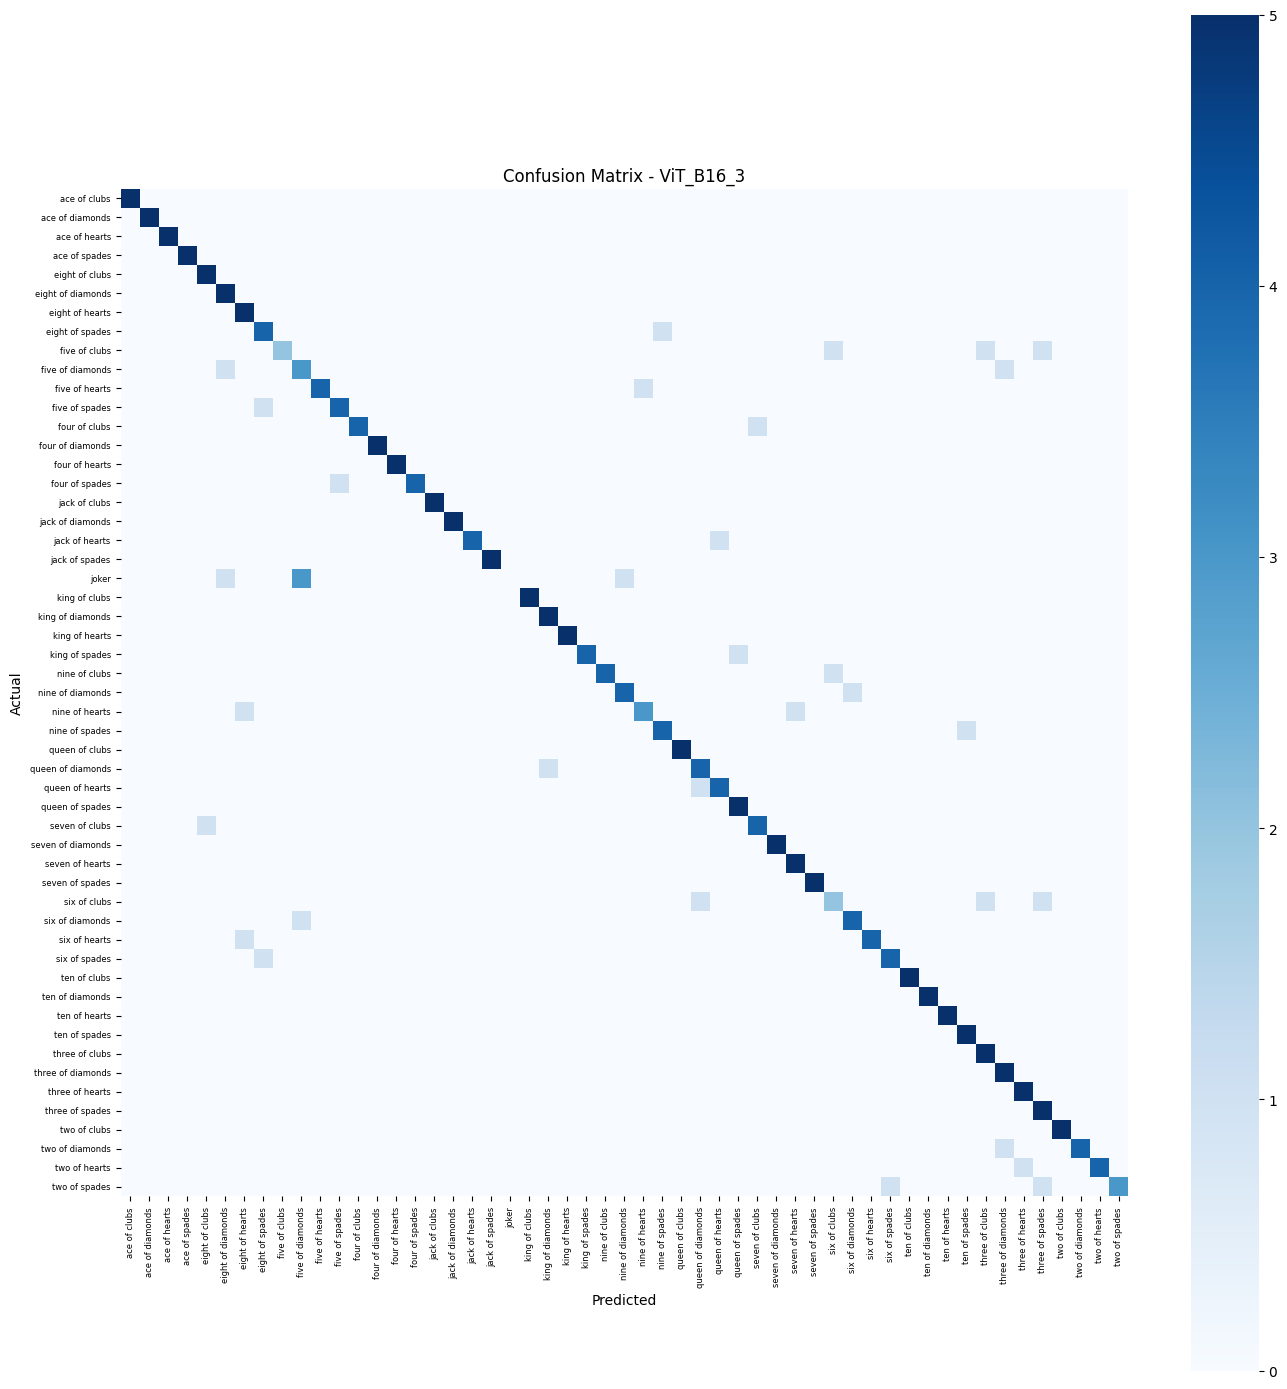

In [ ]:
show_matrix(best_model, test_dataset)